<i>Project 2: Natural Langugage Processing</i> | Dr. LaBrie | Spring 2020


<h1> Microsoft Carbon Negative Effort 2030 </h1>

This dataset presents Microsoft's commitment to sustainability by helping preserve and protect the ecosystem. Last year, Microsoft announced a bold goal and a new plan to reduce and remove carbon footprint. By 2030, they will be carbon negative. By 2050, they will remove all the carbon it has emitted since it was founded in 1975.

The purpose of this project is to analyze patterns and relationships between a set of documents and reveal the terms that are highly used in the reports. The process begins in the order of <i> data exploration, data preparation, modeling, and evaluation. </i> The data exploration will compare the documents in low-dimensional spaces <b>(Document Similarity)</b>, locate recurring topics across documents <b>(Topic Modeling)</b>, and find relations between terms <b>(Text Synonymity)</b>.

In modeling part, we will use a transformation method <b>(TF-IDF)</b> to vectorize the corpus and form a <b>Document-Term Matrix (DTM)</b>. Since <i>Topic Modeling</i> is an unsupervised algorithm, we will use the <b>Truncated Singular Value Decomposition (SVD)</b> to obtain a low-rank approximations to matrices (a rank-<i>r</i> approximation is obtained by keeping the leading <i>r</i> singular values and vectors, and discarding the rest).

Thus, vectorizing these documents and terms will allow us to evaluate the similarity of different documents, the similarity of different words, and the similarity of terms and documents. These can be very useful in information retrieval especially if we would like to retrieve certain context that is relevant to our search query.

Here are the following questions that I would like to address:
1. Given a set of different documents, to what extent they are aligned or persuasively different from each other?
2. What insights have you gained based on the identified themes?
3. How do the identified themes have a statistically significant effect on Microsoft's approach to reduce carbon footprint?

An evaluation of strengths and weaknesses will be assessed at last.

Dataset obtained from Microsoft Reports Hub.
(https://www.microsoft.com/en-us/corporate-responsibility/reports-hub)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from gensim import corpora, models, similarities
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import re
import PyPDF2
%matplotlib inline

In [2]:
# Parse text files
def load_pdf(path, file_name):
    print("Now parsing document {}".format(file_name))
    fpath = os.path.join(path, file_name)
    res = ""
    f = open(fpath, mode='rb')
    reader = PyPDF2.PdfFileReader(f)
    n = reader.getNumPages()
    for i in range(n):
        if i%10 == 0:
            print("Now on page {}/{} ...".format(i+1, n))
        text = reader.getPage(i).extractText().lower()
        text = re.sub(r'[.,!?\n:]', ' ', text)
        res += text
    return res

# Create the path to read all the .pdf files
path = 'C:\data' 
fn_list = os.listdir(path)
doc_set = [load_pdf(path, fn) for fn in fn_list]

Now parsing document 2015CSR.pdf
Now on page 1/71 ...


Now on page 11/71 ...
Now on page 21/71 ...
Now on page 31/71 ...
Now on page 41/71 ...
Now on page 51/71 ...
Now on page 61/71 ...
Now on page 71/71 ...
Now parsing document 2016CSR.pdf
Now on page 1/55 ...
Now on page 11/55 ...
Now on page 21/55 ...
Now on page 31/55 ...
Now on page 41/55 ...
Now on page 51/55 ...
Now parsing document 2017CSR.pdf
Now on page 1/44 ...
Now on page 11/44 ...
Now on page 21/44 ...
Now on page 31/44 ...
Now on page 41/44 ...
Now parsing document 2018CSR.pdf
Now on page 1/60 ...
Now on page 11/60 ...
Now on page 21/60 ...
Now on page 31/60 ...
Now on page 41/60 ...
Now on page 51/60 ...
Now parsing document 2019CSR.pdf
Now on page 1/40 ...
Now on page 11/40 ...
Now on page 21/40 ...
Now on page 31/40 ...
Now parsing document 2019DevicesSustainability.pdf
Now on page 1/113 ...
Now on page 11/113 ...
Now on page 21/113 ...
Now on page 31/113 ...
Now on page 41/113 ...
Now on page 51/113 ...
Now on page 61/113 ...
Now on page 71/113 ...
Now on page 81/113 ...

In [29]:
# Remove words that will dilute the results
remove_set = {'pdf', 'cs', 'th', 'please', 'specific', 'ltd', 'co ltd', 'tuesday', 'july', 'questionnaire', 
              'tion', 'holder', 'easi', 'picture', 'inclus hire', 'blog', 'sub', 'ungp', 'gni', 'dab', 
              'ungp', 'tonn', 'freeli', 'article', 'cdp'}

In [60]:
# Check document words count and stopped words per document
def preprocess_data(doc_set):
    
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create stopwords list
    sw = set(stopwords.words('english'))
    # create Porter Stemmer
    porter_stem = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for doc in doc_set:
        # clean and tokenize document string
        raw = doc.lower()
        print("Length of raw document: {}".format(len(raw)))
        tokens = tokenizer.tokenize(raw)
        # remove stopwords from tokens and only keep the english letter words
        stopped_tokens = [i for i in tokens if not i in sw and i.isalpha()]
        print("Length of stopwords: {}".format(len(stopped_tokens)))

        # stem tokens
        stemmed_tokens = [porter_stem.stem(i) for i in stopped_tokens if i not in remove_set]

        # add tokens to list
        texts.append(stemmed_tokens)

    return texts
    
doc_clean = preprocess_data(doc_set)

Length of raw document: 153651
Length of stopwords: 13049
Length of raw document: 83490
Length of stopwords: 7200
Length of raw document: 49943
Length of stopwords: 4379
Length of raw document: 97954
Length of stopwords: 9061
Length of raw document: 55040
Length of stopwords: 5023
Length of raw document: 239502
Length of stopwords: 20874
Length of raw document: 54347
Length of stopwords: 4831
Length of raw document: 52291
Length of stopwords: 4908
Length of raw document: 92758
Length of stopwords: 8161
Length of raw document: 591538
Length of stopwords: 53966
Length of raw document: 164003
Length of stopwords: 15058


The longest raw word document is 591,538 and shortest is 49,943. While the longest stopwords is 53,996 and shortest is 4,379. The mean for raw word document is 148,593 and stopwords is 13,319.

Please bear in mind that raw document vs stopwords is different. Example of stopwords are not limited to "I", "you", "a", "and", "how", "or", "what", etc.

In [31]:
# Apply count vectorizer & truncated SVD to vectorize the documents
vectorizer = CountVectorizer (ngram_range=(1,2), max_df=.7)
cv = vectorizer.fit_transform([' '.join(doc) for doc in doc_clean])
tfidf_trans = TfidfTransformer()
tfidf = tfidf_trans.fit_transform(cv)
lsa = TruncatedSVD(n_components=3, algorithm='randomized')
lsa_matrix = lsa.fit_transform(tfidf)

In [32]:
# Check if count vectorizer is working
cv

<11x66566 sparse matrix of type '<class 'numpy.int64'>'
	with 88637 stored elements in Compressed Sparse Row format>

In [33]:
# Create list of frequent words and display bar diagram
def plot_frequent_words(fn, cv, cut=30):
    counts = np.sort(cv.toarray()).flatten()[::-1]
    word_indices = np.argsort(cv.toarray()).flatten()[::-1]
    words = np.array(vectorizer.get_feature_names())[word_indices]
    plt.figure(figsize=(10,6))
    plt.bar(np.arange(cut), counts[:cut])
    plt.xticks(np.arange(cut), words[:cut], rotation=90)
    plt.title(fn)

Now, we would like to compare and analyze Microsoft progress on CSR approach and other practices. Let's take a look at these charts.

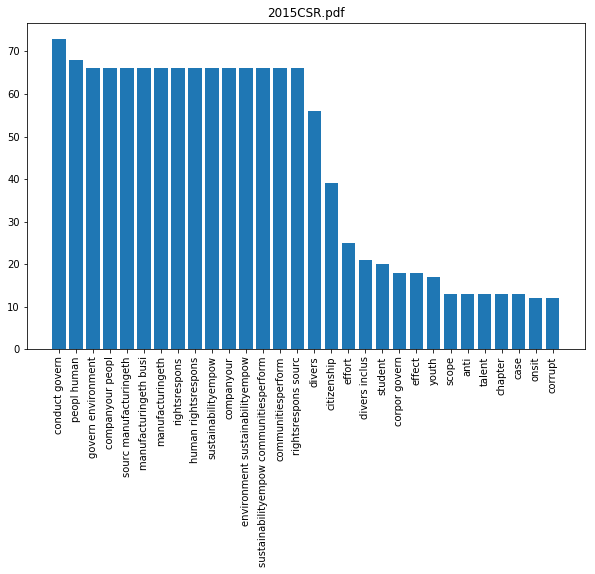

In [34]:
plot_frequent_words(fn_list[0], cv[0,:])

In 2015, the topic report focuses on <i>“conduct government”, “people human”, “govern environment”, “source manufacturing”, “sustainability empowerment”, “human right”.</i>

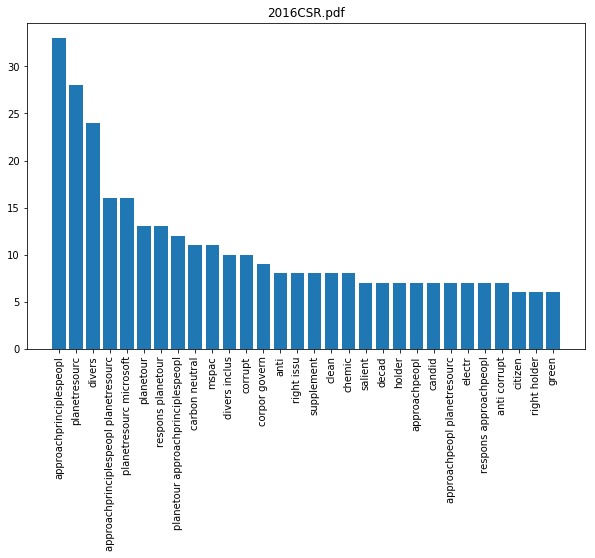

In [35]:
plot_frequent_words(fn_list[1], cv[1,:])

In 2016, the topic report focuses on <i>“approach principle people”, “planet source”, “diverse”, “carbon neutral”, “anti-corrupt”, “green”, “clean”, “planet tour”.</i>

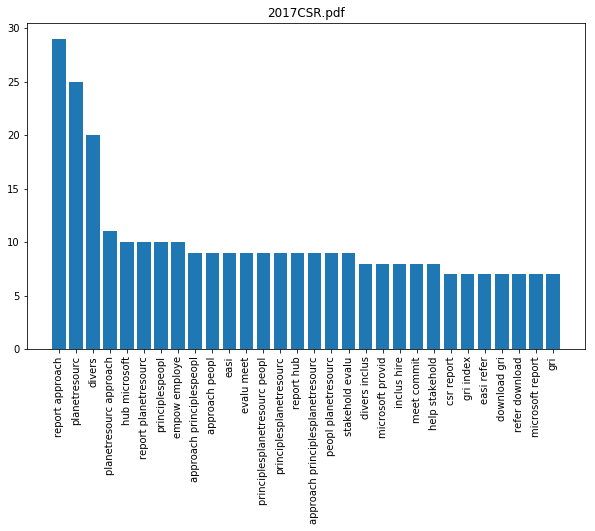

In [36]:
plot_frequent_words(fn_list[2], cv[2,:])

In 2017, the topic report focuses on <i>“report approach”, “planet source”, “empower employee”, “planet resource approach”, “diverse”, “evaluation meet”, “meet commitment”, “gri index” (global reporting initiative)</i>.

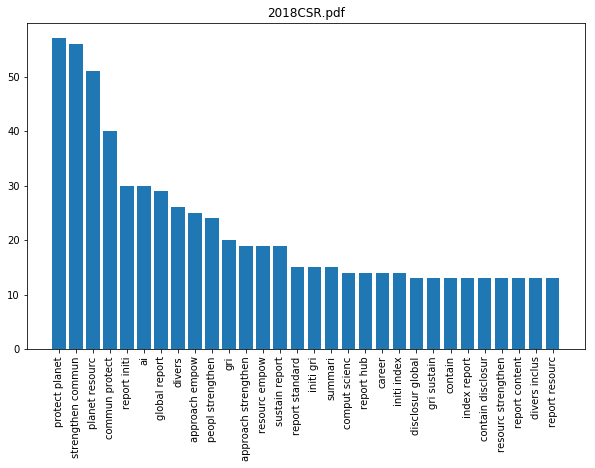

In [37]:
plot_frequent_words(fn_list[3], cv[3,:])

In 2018, the topic report focuses on <i>“protect planet”, “strengthen community”, “planet resource”, “community protect”, “ai”, “diverse”, “approach empowerment”, “people strengthen”, “gri”, “resource strengthen”</i>.

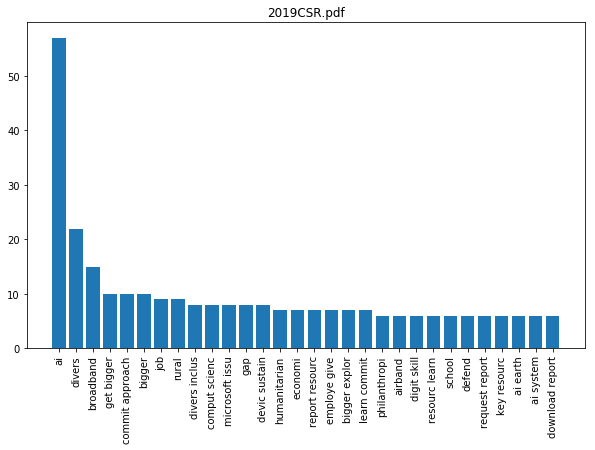

In [38]:
plot_frequent_words(fn_list[4], cv[4,:])

In 2019, the topic report focuses on <i>“ai”, “diverse”, “broadband”, “bigger”, “commit approach”, “job”, “rural”, “computer science”, “device sustainability, “humanitarian”, “philanthropist”, “ai earth”, “ai system” </i>.

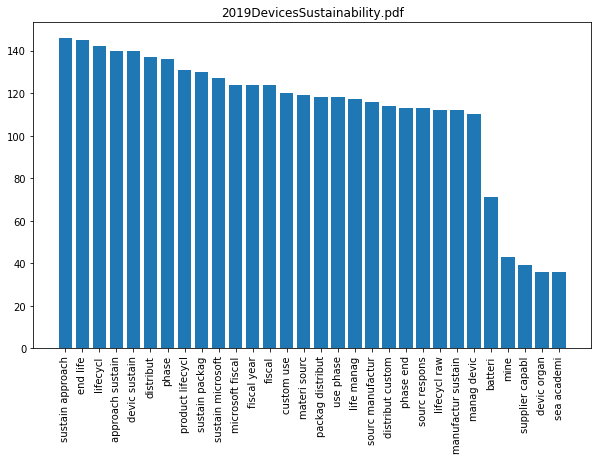

In [39]:
plot_frequent_words(fn_list[5], cv[5,:])

In Devices Sustainability, Microsoft focuses on <i>“sustainable approach”, “end life”, “life cycle”, “device sustainability”, “distribution”, “product life cycle”, “life management”, “source manufacturing”, “material source”</i>.

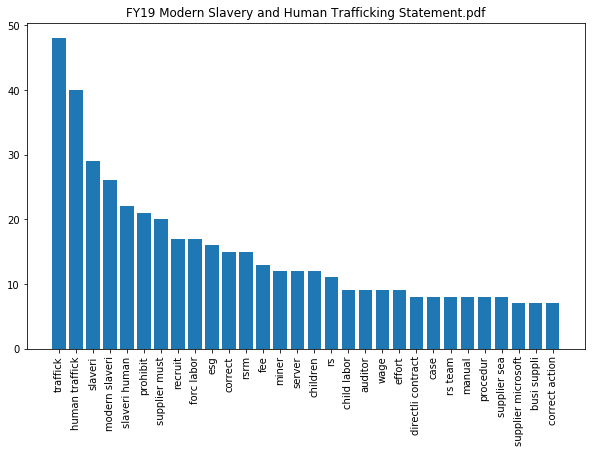

In [40]:
plot_frequent_words(fn_list[6], cv[6,:])

In Modern Slavery & Human Trafficking report, Microsoft considers <i>“trafficking”, “human trafficking”, “modern slavery”, “miner”, “children”, “rs” (responsible sourcing), “wage”, “child labor”</i>.

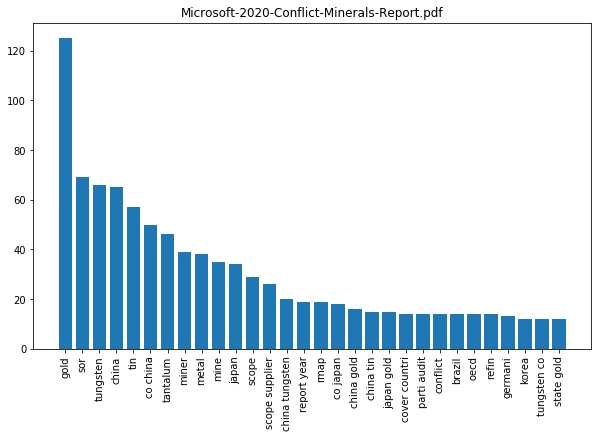

In [41]:
plot_frequent_words(fn_list[7], cv[7,:])

In Conflict Minerals report, Microsoft considers <i>“gold”, “sor” (smelter or refinery), “tungsten”, “china”, “tin”, “tantalum, “miner”, “metal”, “scope”, “supplier”, “conflict”</i>.

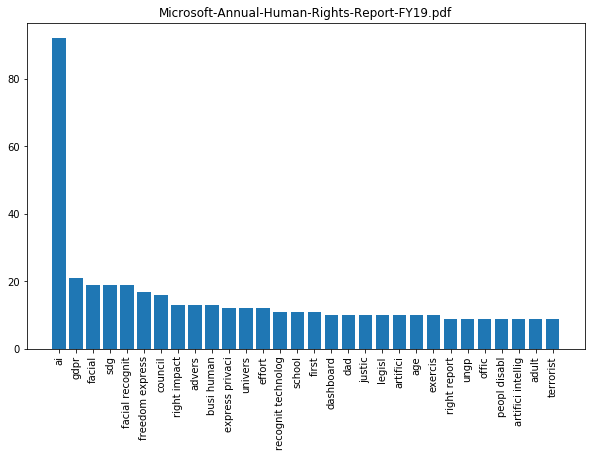

In [42]:
plot_frequent_words(fn_list[8], cv[8,:])

In Human Rights report, Microsoft considers <i>“ai”, “gdpr” (general data protection regulation), “facial recognition”, “right impact”, “recognition technology”, “justice”, “ai”, “express privacy”, “freedom express”</i>.

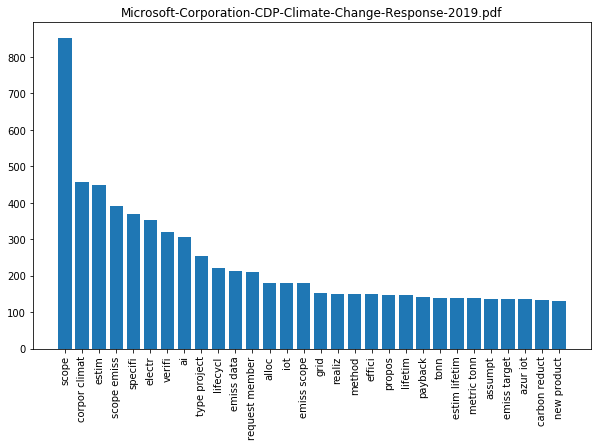

In [43]:
plot_frequent_words(fn_list[9], cv[9,:])

In CDP Climate Change, the topic report focuses on <i>“scope”, “corporate climate”, “scope emission”, “ai”, “lifecycle”, “electricity”, “emission data”, “iot” (internet of things), “emission target”, “carbon reduction”, “new product”</i>.

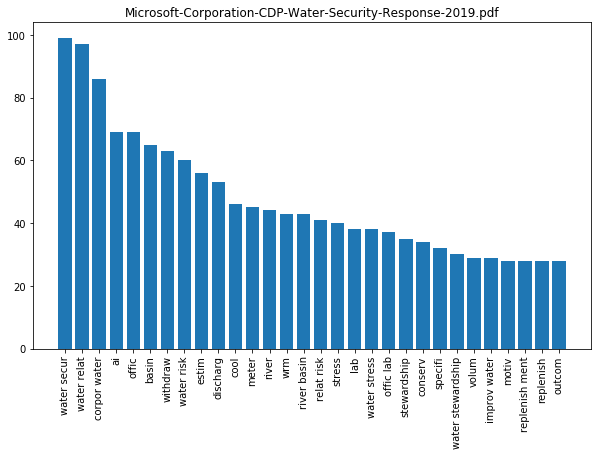

In [44]:
plot_frequent_words(fn_list[10], cv[10,:])

In CDP Water Security, the topic report focuses on <i>“water secure”, “corporate water”, “water risk”, “ai”, “river”, meter”, “river basin”, “water stress”, “stewardship”, “improve water”, “replenishment”</i>.

In [65]:
np.argsort(cv[1,:].toarray())

array([[    0, 43233, 43234, ..., 16830, 43210,  3438]], dtype=int64)

Now, let's create weighted term matrix to further analyze the documents...

In [46]:
# Create tf-idf matrix
def print_topics(model, vectorizer, top_words=5):
    terms = vectorizer.get_feature_names()
    for i, comp in enumerate(model.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:top_words]
        print("Topic "+ str(i) + ": ")
        print(sorted_terms)
        ts = ' '.join([t[0] for t in sorted_terms])
        print(ts)

In [47]:
print_topics(lsa, vectorizer, top_words=10)

Topic 0: 
[('ai', 0.28354687997594075), ('divers', 0.16606957622618612), ('planetresourc', 0.14685556964244906), ('planet resourc', 0.11572770176287045), ('strengthen commun', 0.11033130911199925), ('protect planet', 0.09687484310117471), ('report approach', 0.09493889814382653), ('approachprinciplespeopl', 0.08560318985841431), ('commun protect', 0.07929763807381565), ('divers inclus', 0.07404426763221865)]
ai divers planetresourc planet resourc strengthen commun protect planet report approach approachprinciplespeopl commun protect divers inclus
Topic 1: 
[('scope', 0.18594093487795677), ('estim', 0.15096374180502092), ('corpor climat', 0.12346684287751375), ('specifi', 0.12251729902615195), ('ai', 0.11032867695463502), ('corpor water', 0.10346626742140544), ('water secur', 0.10322068788129733), ('gold', 0.1026434960367902), ('type project', 0.09611894457040263), ('scope emiss', 0.09513804587311996)]
scope estim corpor climat specifi ai corpor water water secur gold type project scope

In [48]:
# Create bar chart to visualize tf-idf
def plot_topics(model, vectorizer, top_words=10):
    terms = vectorizer.get_feature_names()
    for i, comp in enumerate(model.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = np.array(sorted(terms_comp, key= lambda x:x[1], reverse=True)[:top_words])
        fn = "Topic "+ str(i)
        plt.figure(figsize=(10,6))
        plt.bar(np.arange(top_words), sorted_terms[:,1].astype('float'))
        plt.xticks(np.arange(top_words), sorted_terms[:,0], rotation=90)
        plt.title(fn)

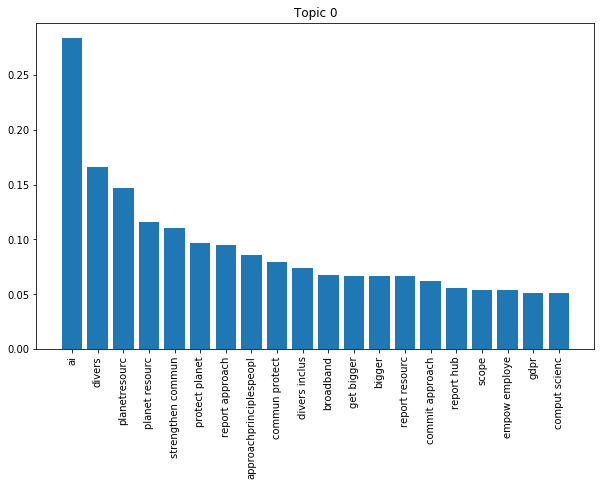

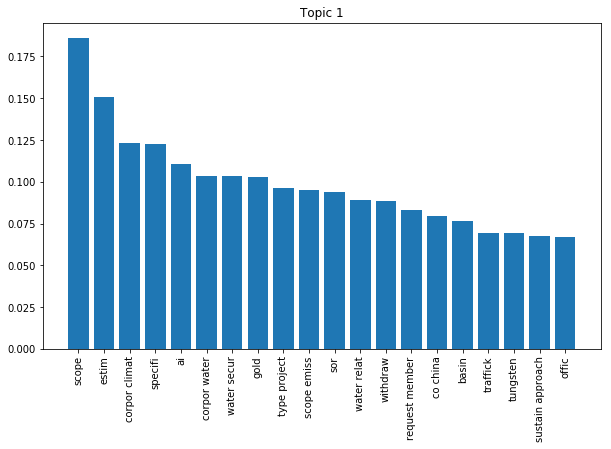

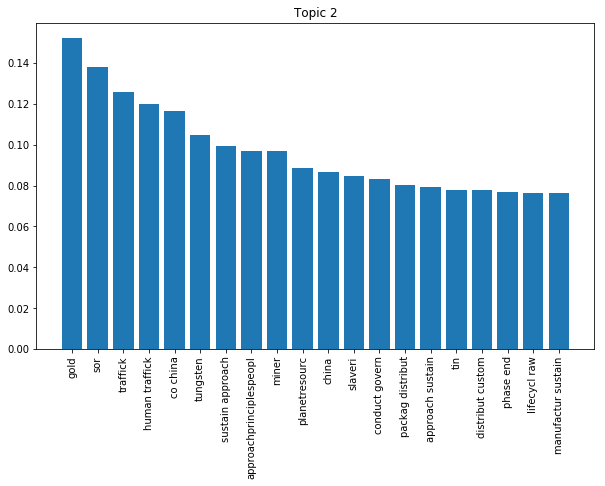

In [58]:
plot_topics(lsa, vectorizer, top_words=20)


Given a set of documents, machine learning predicts there are three different themes. 

The first theme (Topic 0) covers the environmental sustainability approach. Microsoft mentions <i>“artificial intelligence”</i> (AI) as high as 28%. We can predict the company is heavily dependent on AI to preserve Earth’s system and accelerate global progress towards a more sustainable future. For some reason, there are two bars of <i>“planet resource”</i> –if these are combined, the result would be 25%. Microsoft also focuses on <i>“diversity”, “broadband”, “strengthen community”, “protect the planet”, “community protect”, “scope emissions”, and “empower employee”</i>. We strongly believe these are the prominent actions or steps that they adhere to accomplish their 2030 Carbon Negative Mission.

The second theme (Topic 1) covers climate change and water-related issues. <i>“Scope”</i> is the prominent word in the document. Microsoft follows the GHG Protocol Standards to classify its emissions into three scopes. Scope 1 emissions are direct emissions from owned or controlled sources (e.g. car exhaust fumes). Scope 2 emissions are indirect emissions from the generation of purchased energy (e.g. energy sources that light up home or power the buildings). Scope 3 emissions are all indirect emissions that occur in the value chain of the reporting company (e.g. employees’ travel, product full life cycle). Followed by <i>“estimate” , “corporate climate, “ai”, “corporate water”, “gold”, and “project type”</i>. Based on these words, we can predict that Microsoft has set up an estimated timeframe for their projects to achieve their corporate climate standards such as committed to LEED Gold Standards and registering products at EPEAT Gold Level. These would be done with the help of AI as well.  

The third theme (Topic 2) covers conflict minerals, modern slavery, and human trafficking. Microsoft sets high standards for its suppliers and complies with responsible sourcing commitments. <i>“Gold”</i> is one of the conflict minerals that mined in the Democratic Republic of Congo. “SOR” refers to smelters or refiners. Besides, <i>“trafficking”</i> or <i>“human trafficking”</i> is another issue that Microsoft would like to prevent in the supply chain such as corruption and generally poor working conditions. Followed by <i>“Co China”</i> which is related to <i>“SOR”</i> –simply, China is identified in Microsoft Devices’ supply chain which processed 3TGs (Tin, Tantalum, Tungsten, and Gold). We strongly believe that they are taking a sustainable approach seriously by considering different facets such as package distribution, lifecycle, and manufacturing sustainability.


In [50]:
print(fn_list)

['2015CSR.pdf', '2016CSR.pdf', '2017CSR.pdf', '2018CSR.pdf', '2019CSR.pdf', '2019DevicesSustainability.pdf', 'FY19 Modern Slavery and Human Trafficking Statement.pdf', 'Microsoft-2020-Conflict-Minerals-Report.pdf', 'Microsoft-Annual-Human-Rights-Report-FY19.pdf', 'Microsoft-Corporation-CDP-Climate-Change-Response-2019.pdf', 'Microsoft-Corporation-CDP-Water-Security-Response-2019.pdf']


In [51]:
# Create document-term matrix (rows are the docs, the columns are topics of document-topics)
lsa_matrix 

array([[ 0.27020965,  0.0415632 ,  0.35296273],
       [ 0.45438894, -0.18847902,  0.32001157],
       [ 0.5413063 , -0.35064971,  0.07231724],
       [ 0.60511894, -0.25917272, -0.14612674],
       [ 0.63530004, -0.09495748, -0.24037721],
       [ 0.17911986,  0.28810033,  0.39016358],
       [ 0.18966122,  0.25058154,  0.44042747],
       [ 0.10391559,  0.32293348,  0.43588175],
       [ 0.43835078,  0.19047218, -0.25336806],
       [ 0.23696512,  0.58824739, -0.19687228],
       [ 0.23036198,  0.54610599, -0.34637112]])

In [52]:
# Create list chart visualization
result_df = pd.DataFrame(lsa_matrix, columns=["Topic "+ str(i) for i in range(lsa_matrix.shape[1])])

In [53]:
result_df['filename'] = fn_list

In [54]:
# Visualize weighted tf-idf relevancy with other document-topics
result_df

,Topic 0,Topic 1,Topic 2,filename
0,0.270210,0.041563,0.352963,2015CSR.pdf
1,0.454389,-0.188479,0.320012,2016CSR.pdf
2,0.541306,-0.350650,0.072317,2017CSR.pdf
3,0.605119,-0.259173,-0.146127,2018CSR.pdf
4,0.635300,-0.094957,-0.240377,2019CSR.pdf
5,0.179120,0.288100,0.390164,2019DevicesSustainability.pdf
6,0.189661,0.250582,0.440427,FY19 Modern Slavery and Human Trafficking Stat...
7,0.103916,0.322933,0.435882,Microsoft-2020-Conflict-Minerals-Report.pdf
8,0.438351,0.190472,-0.253368,Microsoft-Annual-Human-Rights-Report-FY19.pdf
9,0.236965,0.588247,-0.196872,Microsoft-Corporation-CDP-Climate-Change-Respo...


Surprisingly, three documents catch our attention:
1.	2015 CSR’s content inclines to Topic 2 rather than Topic 1.
2.	2019 Devices Sustainability’s content inclines to Topic 2.
3.	Microsoft Annual Human Rights Report’s content inclines to Topic 0. 

We learn that document titles do not dictate the document content at certain times. The negative shows that they are not related to the topic.


<h3>Conclusion</h3>

Interestingly, Microsoft mentions <i>“broadband”</i>, <i>job</i> and <i>“rural”</i>. As Microsoft relies on AI technology, cloud computing becomes a fundamental block. Though these terms seem to do not have any relations, it is a part of their project to achieve Microsoft’s Airband Initiative. Many rural areas lack broadband access which limits their ability to thrive in a digital economy. They will pursue to extend broadband access to 3 million Americas in rural areas by July 2020. (https://blogs.microsoft.com/on-the-issues/2018/12/03/the-rural-broadband-divide-an-urgent-national-problem-that-we-can-solve/). 

Tracing back five years ago, Microsoft already has a vision and plan to build a planetary computer. They have repeatedly mentioned <i>“planet source”, “carbon neutral”, “diverse”, “protect planet”, “strengthen community”, “ai”, “gri index”, etc.</i> Non-CSR reports have supported its decision in building a better world by benefiting AI technology, encouraging stewardship, empowering employees, committing to responsible material manufacturing, promoting child labor free, aiming for carbon reduction, and so on.

Microsoft is building an AI system for the Earth in the next 10 years. This will build an interconnected environmental network of data and tools. Yes, it is a  <b><u>BOLD</b></u> commitment to achieving humanitarian and philanthropist goals!